In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import pandas as pd
from pandas import DataFrame as dframe
import cvxpy as cv

In [14]:
def Dic(feat_l_tr,feat_r_tr): #入力の配列は2次元配列である必要がある
    feat_tr = np.concatenate([feat_l_tr, feat_r_tr],0)
    return feat_tr

In [15]:
def SRC(feat_tr_dic,feat_l_te,matrix_index):
    answer = np.zeros(feat_l_te.shape[1])
    SRC_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    SRC_l_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    SRC_r_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    for i in range(feat_l_te.shape[1]):
        x = cv.Variable((feat_tr_dic.shape[1],1)) #目的関数の次元
        objective = cv.Minimize(cv.norm(x,1))
        constraints = [feat_l_te[:,i,np.newaxis] == feat_tr_dic@x]
        prob = cv.Problem(objective, constraints)
        result = prob.solve()
        #classVariableから値を取るためには.valueを付ける
        SRC_Cla[:,i] = np.squeeze(x.value)
        #各クラスに関連する表現ベクトルの値を抜き出す
        #lは仕切りの値
        l = 0
        j = 0
        while j < matrix_index.shape[0]-1:
            SRC_l_Cla[l:l+matrix_index[j],i] = SRC_Cla[l:l+matrix_index[j],i]     
            l = l + matrix_index[j]
            j = j + 1
            SRC_r_Cla[l:l+matrix_index[j],i] = SRC_Cla[l:l+matrix_index[j],i]
            l = l + matrix_index[j]
            j = j + 1
    #パラメータを使って擬似的に各クラスのテスト信号の特徴ベクトルを作成
    dout_feat_l_te = np.zeros((feat_l_te.shape[0], feat_l_te.shape[1]))
    dout_feat_r_te = np.zeros((feat_l_te.shape[0], feat_l_te.shape[1])) 
    for i in range(feat_l_te.shape[1]):
        dout_feat_l_te[:,i] = feat_tr_dic@SRC_l_Cla[:,i]
    for i in range(feat_l_te.shape[1]):
        dout_feat_r_te[:,i] = feat_tr_dic@SRC_r_Cla[:,i]
    #作成した擬似特徴ベクトルとの残差を求める
    R_l =  np.zeros((feat_l_te.shape[0], feat_l_te.shape[1])) #残差を格納するための配列
    R_r =  np.zeros((feat_l_te.shape[0], feat_l_te.shape[1]))  
    for i in range(feat_l_te.shape[1]):
        R_l[:,i] = feat_l_te[:,i]-dout_feat_l_te[:,i]
        R_r[:,i] = feat_l_te[:,i]-dout_feat_r_te[:,i]
        if np.linalg.norm(R_l[:,i], ord=2) < np.linalg.norm(R_r[:,i], ord=2):
            answer[i] = 1
        elif np.linalg.norm(R_l[:,i], ord=2) > np.linalg.norm(R_r[:,i], ord=2):
            answer[i] = 2
    return answer

In [16]:
def SRC_test(filename1,filename2,filename3,filename4,C1_K1,C2_K1,C1_K2,C2_K2,C1_K3,C2_K3,C1_K4,C2_K4):
    #対象被験者の特徴ベクトルをMATLABから入手
    feat_C1 = np.loadtxt(filename1,delimiter=",")
    feat_C2 = np.loadtxt(filename2,delimiter=",")
    feat_Test_C1 = np.loadtxt(filename3,delimiter=",")
    feat_Test_C2 = np.loadtxt(filename4,delimiter=",")
    #非対象被験者の特徴ベクトルをMATLABから入手
    feat_C1_K1 = np.loadtxt(C1_K1,delimiter=",")
    feat_C2_K1 = np.loadtxt(C2_K1,delimiter=",")
    feat_C1_K2 = np.loadtxt(C1_K2,delimiter=",")
    feat_C2_K2 = np.loadtxt(C1_K2,delimiter=",")
    feat_C1_K3 = np.loadtxt(C1_K3,delimiter=",")
    feat_C2_K3 = np.loadtxt(C1_K3,delimiter=",")
    feat_C1_K4 = np.loadtxt(C1_K4,delimiter=",")
    feat_C2_K4 = np.loadtxt(C1_K4,delimiter=",")
    #Tは被験者の試行回数である
    feat_tr = Dic(feat_C1,feat_C2)
    #非対象被験者の特徴ベクトルも同様の処理を行う
    feat_tr_K1 = Dic(feat_C1_K1,feat_C2_K1)
    feat_tr_K2 = Dic(feat_C1_K2,feat_C2_K2)
    feat_tr_K3 = Dic(feat_C1_K3,feat_C2_K3)
    feat_tr_K4 = Dic(feat_C1_K4,feat_C2_K4)

    #それぞれの特徴ベクトルをつなげる
    feat_tr_dic_1 = Dic(feat_tr,feat_tr_K1)
    feat_tr_dic_2 = Dic(feat_tr_dic_1,feat_tr_K2)
    feat_tr_dic_3 = Dic(feat_tr_dic_2,feat_tr_K3)
    feat_tr_dic = Dic(feat_tr_dic_3,feat_tr_K4).T
    #feat_tr_dicはすべての特徴ベクトルをつなげたもの
    #まず、分類に用いるテストデータの特徴ベクトルを2次元に変換
    feat_l_te = feat_Test_C1;
    feat_r_te = feat_Test_C2;
    feat_l_te = feat_l_te.T
    feat_r_te = feat_r_te.T

    matrix_index = np.array([feat_C1.shape[0],feat_C2.shape[0],feat_C1_K1.shape[0],feat_C2_K1.shape[0],feat_C1_K2.shape[0],feat_C2_K2.shape[0],
                        feat_C1_K3.shape[0],feat_C2_K3.shape[0],feat_C1_K4.shape[0],feat_C2_K4.shape[0]])
    answer1 = SRC(feat_tr_dic,feat_l_te,matrix_index)
    answer2 = SRC(feat_tr_dic,feat_r_te,matrix_index)
    x1 = 0
    x2 = 0
    for i in range(answer1.shape[0]):
        if answer1[i] == 1:
            x1 = x1 + 1
        if answer2[i] == 2:
            x2 = x2 + 1
    temp = ((x1+x2)/(answer1.shape[0]+answer2.shape[0]))*100
    temp1 = ((x1)/(answer1.shape[0]))*100
    temp2 = ((x2)/(answer2.shape[0]))*100
                    
    return temp,temp1,temp2

In [17]:
#train=20,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A01T_20_K0.txt","feat_2a_250Hz_20/feat_right_A01T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A01T_20.txt","feat_2a_250Hz_20/feat_test_right_A01T_20.txt"
                           ,"feat_2a_250Hz_20/feat_left_A02T_20.txt","feat_2a_250Hz_20/feat_right_A02T_20.txt","feat_2a_250Hz_20/feat_left_A03T_20.txt","feat_2a_250Hz_20/feat_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20/feat_left_A06T_20.txt","feat_2a_250Hz_20/feat_right_A06T_20.txt","feat_2a_250Hz_20/feat_left_A09T_20.txt","feat_2a_250Hz_20/feat_right_A09T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A02T_20_K0.txt","feat_2a_250Hz_20/feat_right_A02T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A02T_20.txt","feat_2a_250Hz_20/feat_test_right_A02T_20.txt"
                           ,"feat_2a_250Hz_20/feat_left_A01T_20.txt","feat_2a_250Hz_20/feat_right_A01T_20.txt","feat_2a_250Hz_20/feat_left_A03T_20.txt","feat_2a_250Hz_20/feat_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20/feat_left_A06T_20.txt","feat_2a_250Hz_20/feat_right_A06T_20.txt","feat_2a_250Hz_20/feat_left_A09T_20.txt","feat_2a_250Hz_20/feat_right_A09T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A03T_20_K0.txt","feat_2a_250Hz_20/feat_right_A03T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A03T_20.txt","feat_2a_250Hz_20/feat_test_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20/feat_left_A02T_20.txt","feat_2a_250Hz_20/feat_right_A02T_20.txt","feat_2a_250Hz_20/feat_left_A01T_20.txt","feat_2a_250Hz_20/feat_right_A01T_20.txt"
                           ,"feat_2a_250Hz_20/feat_left_A06T_20.txt","feat_2a_250Hz_20/feat_right_A06T_20.txt","feat_2a_250Hz_20/feat_left_A09T_20.txt","feat_2a_250Hz_20/feat_right_A09T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A07T_20_K0.txt","feat_2a_250Hz_20/feat_right_A07T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A07T_20.txt","feat_2a_250Hz_20/feat_test_right_A07T_20.txt"
                           ,"feat_2a_250Hz_20/feat_left_A02T_20.txt","feat_2a_250Hz_20/feat_right_A02T_20.txt","feat_2a_250Hz_20/feat_left_A03T_20.txt","feat_2a_250Hz_20/feat_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20/feat_left_A01T_20.txt","feat_2a_250Hz_20/feat_right_A01T_20.txt","feat_2a_250Hz_20/feat_left_A09T_20.txt","feat_2a_250Hz_20/feat_right_A09T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
emp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A08T_20_K0.txt","feat_2a_250Hz_20/feat_right_A08T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A08T_20.txt","feat_2a_250Hz_20/feat_test_right_A08T_20.txt"
                           ,"feat_2a_250Hz_20/feat_left_A02T_20.txt","feat_2a_250Hz_20/feat_right_A02T_20.txt","feat_2a_250Hz_20/feat_left_A03T_20.txt","feat_2a_250Hz_20/feat_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20/feat_left_A01T_20.txt","feat_2a_250Hz_20/feat_right_A01T_20.txt","feat_2a_250Hz_20/feat_left_A09T_20.txt","feat_2a_250Hz_20/feat_right_A09T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([5, 3])
print(probability_1)

[[50.   10.   90.  ]
 [48.75  0.   97.5 ]
 [55.   42.5  67.5 ]
 [50.   32.5  67.5 ]
 [50.    5.   95.  ]]


In [18]:
#train=20,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A01T_20_K0.txt","feat_2a_250Hz_20/feat_right_A01T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A01T_20.txt","feat_2a_250Hz_20/feat_test_right_A01T_20.txt"
                           ,"feat_2a_250Hz_20_2/feat_left_A02T_20.txt","feat_2a_250Hz_20_2/feat_right_A02T_20.txt","feat_2a_250Hz_20_2/feat_left_A03T_20.txt","feat_2a_250Hz_20_2/feat_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20_2/feat_left_A06T_20.txt","feat_2a_250Hz_20_2/feat_right_A06T_20.txt","feat_2a_250Hz_20_2/feat_left_A09T_20.txt","feat_2a_250Hz_20_2/feat_right_A09T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A02T_20_K0.txt","feat_2a_250Hz_20/feat_right_A02T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A02T_20.txt","feat_2a_250Hz_20/feat_test_right_A02T_20.txt"
                           ,"feat_2a_250Hz_20_2/feat_left_A01T_20.txt","feat_2a_250Hz_20_2/feat_right_A01T_20.txt","feat_2a_250Hz_20_2/feat_left_A03T_20.txt","feat_2a_250Hz_20_2/feat_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20_2/feat_left_A06T_20.txt","feat_2a_250Hz_20_2/feat_right_A06T_20.txt","feat_2a_250Hz_20_2/feat_left_A09T_20.txt","feat_2a_250Hz_20_2/feat_right_A09T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A03T_20_K0.txt","feat_2a_250Hz_20/feat_right_A03T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A03T_20.txt","feat_2a_250Hz_20/feat_test_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20_2/feat_left_A02T_20.txt","feat_2a_250Hz_20_2/feat_right_A02T_20.txt","feat_2a_250Hz_20_2/feat_left_A01T_20.txt","feat_2a_250Hz_20_2/feat_right_A01T_20.txt"
                           ,"feat_2a_250Hz_20_2/feat_left_A06T_20.txt","feat_2a_250Hz_20_2/feat_right_A06T_20.txt","feat_2a_250Hz_20_2/feat_left_A09T_20.txt","feat_2a_250Hz_20_2/feat_right_A09T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A07T_20_K0.txt","feat_2a_250Hz_20/feat_right_A07T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A07T_20.txt","feat_2a_250Hz_20/feat_test_right_A07T_20.txt"
                           ,"feat_2a_250Hz_20_2/feat_left_A02T_20.txt","feat_2a_250Hz_20_2/feat_right_A02T_20.txt","feat_2a_250Hz_20_2/feat_left_A03T_20.txt","feat_2a_250Hz_20_2/feat_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20_2/feat_left_A01T_20.txt","feat_2a_250Hz_20_2/feat_right_A01T_20.txt","feat_2a_250Hz_20_2/feat_left_A09T_20.txt","feat_2a_250Hz_20_2/feat_right_A09T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
emp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A08T_20_K0.txt","feat_2a_250Hz_20/feat_right_A08T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A08T_20.txt","feat_2a_250Hz_20/feat_test_right_A08T_20.txt"
                           ,"feat_2a_250Hz_20_2/feat_left_A02T_20.txt","feat_2a_250Hz_20_2/feat_right_A02T_20.txt","feat_2a_250Hz_20_2/feat_left_A03T_20.txt","feat_2a_250Hz_20_2/feat_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20_2/feat_left_A01T_20.txt","feat_2a_250Hz_20_2/feat_right_A01T_20.txt","feat_2a_250Hz_20_2/feat_left_A09T_20.txt","feat_2a_250Hz_20_2/feat_right_A09T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([5, 3])
print(probability_2)

[[51.25 12.5  90.  ]
 [51.25  5.   97.5 ]
 [51.25 30.   72.5 ]
 [46.25 92.5   0.  ]
 [46.25 75.   42.5 ]]


In [19]:
#train=20,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A01T_20_K0.txt","feat_2a_250Hz_20/feat_right_A01T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A01T_20.txt","feat_2a_250Hz_20/feat_test_right_A01T_20.txt"
                           ,"feat_2a_250Hz_20_3/feat_left_A02T_20.txt","feat_2a_250Hz_20_3/feat_right_A02T_20.txt","feat_2a_250Hz_20_3/feat_left_A03T_20.txt","feat_2a_250Hz_20_3/feat_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20_3/feat_left_A06T_20.txt","feat_2a_250Hz_20_3/feat_right_A06T_20.txt","feat_2a_250Hz_20_3/feat_left_A09T_20.txt","feat_2a_250Hz_20_3/feat_right_A09T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A02T_20_K0.txt","feat_2a_250Hz_20/feat_right_A02T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A02T_20.txt","feat_2a_250Hz_20/feat_test_right_A02T_20.txt"
                           ,"feat_2a_250Hz_20_3/feat_left_A01T_20.txt","feat_2a_250Hz_20_3/feat_right_A01T_20.txt","feat_2a_250Hz_20_3/feat_left_A03T_20.txt","feat_2a_250Hz_20_3/feat_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20_3/feat_left_A06T_20.txt","feat_2a_250Hz_20_3/feat_right_A06T_20.txt","feat_2a_250Hz_20_3/feat_left_A09T_20.txt","feat_2a_250Hz_20_3/feat_right_A09T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A03T_20_K0.txt","feat_2a_250Hz_20/feat_right_A03T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A03T_20.txt","feat_2a_250Hz_20/feat_test_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20_3/feat_left_A02T_20.txt","feat_2a_250Hz_20_3/feat_right_A02T_20.txt","feat_2a_250Hz_20_3/feat_left_A01T_20.txt","feat_2a_250Hz_20_3/feat_right_A01T_20.txt"
                           ,"feat_2a_250Hz_20_3/feat_left_A06T_20.txt","feat_2a_250Hz_20_3/feat_right_A06T_20.txt","feat_2a_250Hz_20_3/feat_left_A09T_20.txt","feat_2a_250Hz_20_3/feat_right_A09T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A07T_20_K0.txt","feat_2a_250Hz_20/feat_right_A07T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A07T_20.txt","feat_2a_250Hz_20/feat_test_right_A07T_20.txt"
                           ,"feat_2a_250Hz_20_3/feat_left_A02T_20.txt","feat_2a_250Hz_20_3/feat_right_A02T_20.txt","feat_2a_250Hz_20_3/feat_left_A03T_20.txt","feat_2a_250Hz_20_3/feat_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20_3/feat_left_A01T_20.txt","feat_2a_250Hz_20_3/feat_right_A01T_20.txt","feat_2a_250Hz_20_3/feat_left_A09T_20.txt","feat_2a_250Hz_20_3/feat_right_A09T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
emp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A08T_20_K0.txt","feat_2a_250Hz_20/feat_right_A08T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A08T_20.txt","feat_2a_250Hz_20/feat_test_right_A08T_20.txt"
                           ,"feat_2a_250Hz_20_3/feat_left_A02T_20.txt","feat_2a_250Hz_20_3/feat_right_A02T_20.txt","feat_2a_250Hz_20_3/feat_left_A03T_20.txt","feat_2a_250Hz_20_3/feat_right_A03T_20.txt"
                           ,"feat_2a_250Hz_20_3/feat_left_A01T_20.txt","feat_2a_250Hz_20_3/feat_right_A01T_20.txt","feat_2a_250Hz_20_3/feat_left_A09T_20.txt","feat_2a_250Hz_20_3/feat_right_A09T_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([5, 3])
print(probability_2)

[[51.25 12.5  90.  ]
 [51.25  5.   97.5 ]
 [51.25 30.   72.5 ]
 [46.25 92.5   0.  ]
 [46.25 75.   42.5 ]]


In [22]:
p_average = (probability_1+probability_2+probability_3)/3
print(p_average)

[[52.5        16.66666667 88.33333333]
 [49.58333333 14.16666667 85.        ]
 [52.5        56.66666667 48.33333333]
 [48.33333333 67.5        29.16666667]
 [48.33333333 55.83333333 51.66666667]]


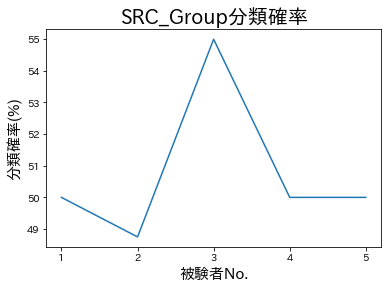

In [17]:
import matplotlib.pyplot as plt
import japanize_matplotlib
x = np.arange(1, 6, step=1)
y = probability[:,0]
plt.title("SRC_Group分類確率", {"fontsize":20})
plt.xlabel("被験者No.", {"fontsize":15})
plt.ylabel("分類確率(%)", {"fontsize":15})
plt.plot(x,y)
plt.xticks(np.arange(1, 6, step=1))
plt.savefig("2a_SRC_group_probability_20.pdf")
plt.show()

In [19]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A01T_20_K0.txt","feat_2a_250Hz_20/feat_right_A01T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A01T_20.txt","feat_2a_250Hz_20/feat_test_right_A01T_20.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A06T_30.txt","feat_2a_250Hz_30/feat_right_A06T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A02T_20_K0.txt","feat_2a_250Hz_20/feat_right_A02T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A02T_20.txt","feat_2a_250Hz_20/feat_test_right_A02T_20.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A06T_30.txt","feat_2a_250Hz_30/feat_right_A06T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A03T_20_K0.txt","feat_2a_250Hz_20/feat_right_A03T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A03T_20.txt","feat_2a_250Hz_20/feat_test_right_A03T_20.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A06T_30.txt","feat_2a_250Hz_30/feat_right_A06T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A07T_20_K0.txt","feat_2a_250Hz_20/feat_right_A07T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A07T_20.txt","feat_2a_250Hz_20/feat_test_right_A07T_20.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
emp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A08T_20_K0.txt","feat_2a_250Hz_20/feat_right_A08T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A08T_20.txt","feat_2a_250Hz_20/feat_test_right_A08T_20.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([5, 3])
print(probability_1)

[[61.25 40.   82.5 ]
 [47.5   0.   95.  ]
 [45.   65.   25.  ]
 [52.5  45.   60.  ]
 [52.5  50.   42.5 ]]


In [23]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A01T_20_K0.txt","feat_2a_250Hz_20/feat_right_A01T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A01T_20.txt","feat_2a_250Hz_20/feat_test_right_A01T_20.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A06T_30.txt","feat_2a_250Hz_30_2/feat_right_A06T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A02T_20_K0.txt","feat_2a_250Hz_20/feat_right_A02T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A02T_20.txt","feat_2a_250Hz_20/feat_test_right_A02T_20.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A06T_30.txt","feat_2a_250Hz_30_2/feat_right_A06T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A03T_20_K0.txt","feat_2a_250Hz_20/feat_right_A03T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A03T_20.txt","feat_2a_250Hz_20/feat_test_right_A03T_20.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A06T_30.txt","feat_2a_250Hz_30_2/feat_right_A06T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A07T_20_K0.txt","feat_2a_250Hz_20/feat_right_A07T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A07T_20.txt","feat_2a_250Hz_20/feat_test_right_A07T_20.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
emp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A08T_20_K0.txt","feat_2a_250Hz_20/feat_right_A08T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A08T_20.txt","feat_2a_250Hz_20/feat_test_right_A08T_20.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([5, 3])
print(probability_2)

[[55.   22.5  87.5 ]
 [48.75  0.   97.5 ]
 [57.5  77.5  37.5 ]
 [48.75 95.    2.5 ]
 [48.75 22.5  85.  ]]


In [26]:
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A01T_20_K0.txt","feat_2a_250Hz_20/feat_right_A01T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A01T_20.txt","feat_2a_250Hz_20/feat_test_right_A01T_20.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A06T_30.txt","feat_2a_250Hz_30_3/feat_right_A06T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A02T_20_K0.txt","feat_2a_250Hz_20/feat_right_A02T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A02T_20.txt","feat_2a_250Hz_20/feat_test_right_A02T_20.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A06T_30.txt","feat_2a_250Hz_30_3/feat_right_A06T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A03T_20_K0.txt","feat_2a_250Hz_20/feat_right_A03T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A03T_20.txt","feat_2a_250Hz_20/feat_test_right_A03T_20.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A06T_30.txt","feat_2a_250Hz_30_3/feat_right_A06T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A07T_20_K0.txt","feat_2a_250Hz_20/feat_right_A07T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A07T_20.txt","feat_2a_250Hz_20/feat_test_right_A07T_20.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
emp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A08T_20_K0.txt","feat_2a_250Hz_20/feat_right_A08T_20_K0.txt","feat_2a_250Hz_20/feat_test_left_A08T_20.txt","feat_2a_250Hz_20/feat_test_right_A08T_20.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([5, 3])
print(probability_3)

[[50.   30.   70.  ]
 [50.    2.5  97.5 ]
 [56.25 50.   62.5 ]
 [48.75 95.    2.5 ]
 [48.75 25.   75.  ]]


In [27]:
p_average = (probability_1+probability_2+probability_3)/3
print(p_average)

[[51.66666667 20.83333333 82.5       ]
 [49.16666667  0.83333333 97.5       ]
 [56.25       56.66666667 55.83333333]
 [49.16666667 74.16666667 24.16666667]
 [49.16666667 17.5        85.        ]]


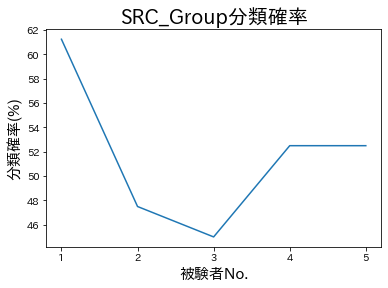

In [20]:
import matplotlib.pyplot as plt
import japanize_matplotlib
x = np.arange(1, 6, step=1)
y = probability[:,0]
plt.title("SRC_Group分類確率", {"fontsize":20})
plt.xlabel("被験者No.", {"fontsize":15})
plt.ylabel("分類確率(%)", {"fontsize":15})
plt.plot(x,y)
plt.xticks(np.arange(1, 6, step=1))
plt.savefig("2a_SRC_group_probability_30.pdf")
plt.show()